# Титаник

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

### Задание: Провести разведочный анализ, построить диаграммы распределений пасажиров по каждому из признаков. Построить графики совместного распределения для всех признаков.

In [2]:
data_train = pd.read_csv("train.csv")
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Поищем пропущенные значения.**

In [3]:
def count_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    share = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    percent = round(share * 100).astype(int).astype(str) + '%'
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

count_missing_data(data_train)

,Total,Percent
Cabin,687,77%
Age,177,20%
Embarked,2,0%
PassengerId,0,0%
Survived,0,0%
Pclass,0,0%
Name,0,0%
Sex,0,0%
SibSp,0,0%
Parch,0,0%


Выводы:
* Переменная Cabin имеет много NA. Использовать ее в модели не будем.
* В Age также отсутствуют почти 20% значений, однако эта переменная может быть важна для прогнозирования выживаемости (например, дети с большей вероятностью будут спасены). NA в этой переменной следует обработать по-другому.
* У Embarked всего 2 NA, поэтому я просто удалю эти наблюдения.

**Посмотрим на статистику.**

In [4]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Выводы:
* Каких-либо странностей (вроде отрицательного возраста) в данных нет. 

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Проверим, есть ли дубликаты.**

In [6]:
print(f"В данных {data_train.duplicated().sum()} дубликатов")

В данных 0 дубликатов


**Разделим переменные на категориальные и количественные.**

In [7]:
numerical = ["SibSp", "Parch", "Age", "Fare"]
categorical = ["Sex", "Embarked", "Pclass"]
target = "Survived"

Посмотрим на графики распределений для количественных переменных.

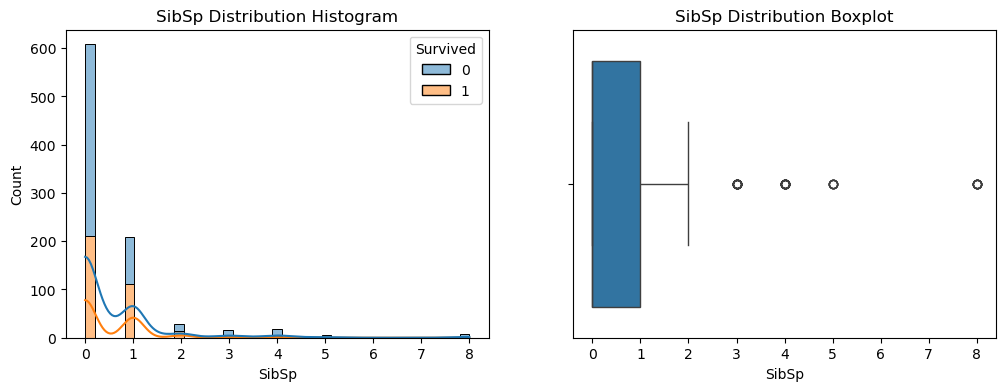

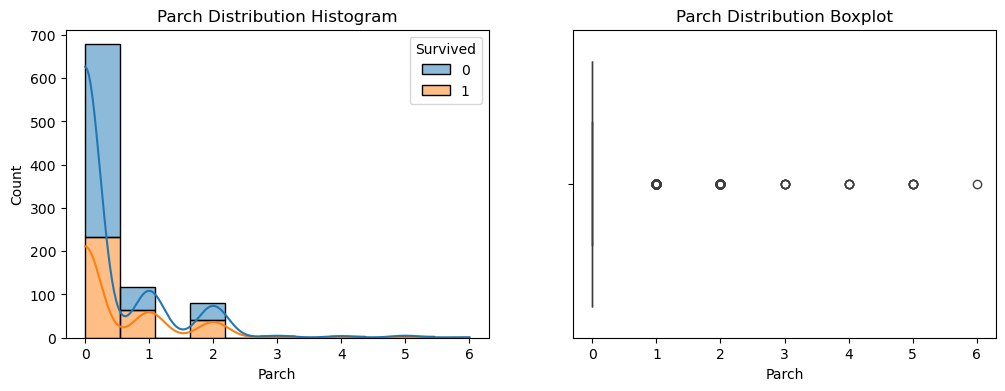

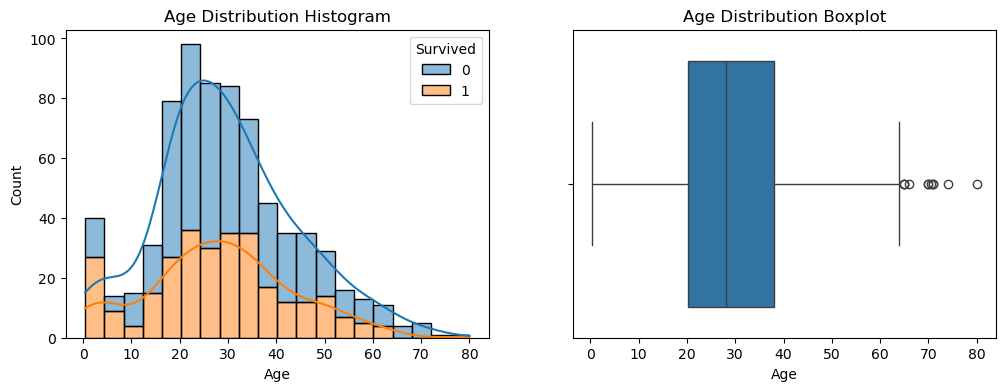

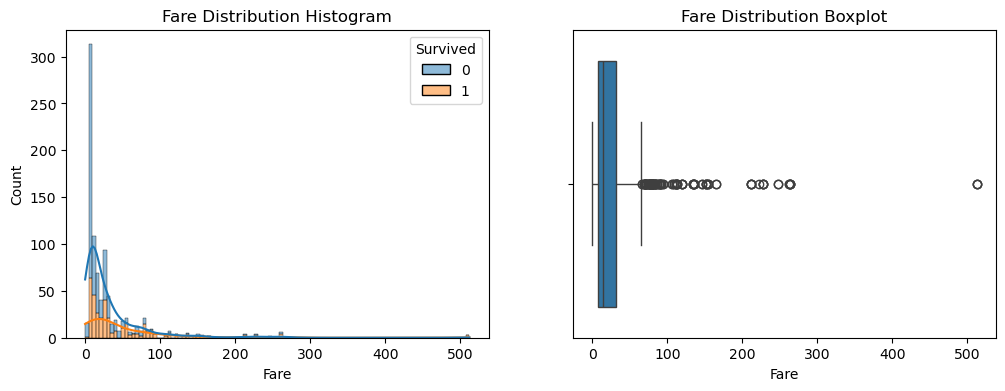

In [8]:
def num_dist(data, var):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(data=data, x=var, kde=True, ax=ax[0], hue="Survived", multiple="stack")
    sns.boxplot(data=data, x=var, ax=ax[1])
    ax[0].set_title(f"{var} Distribution Histogram")
    ax[1].set_title(f"{var} Distribution Boxplot")
    plt.show()
    
for var in numerical:
    num_dist(data_train, var)

Основные моменты:
* Средний возраст пассажиров – около 30 лет. Однако возраст может варьироваться от нескольких месяцев до 80 лет. 
* Среди детей выше доля выживших.
* Согласно графикам Parch и SibSp, большинство людей путешествовало в одиночку. Однако среди тех, кто путешествовал с родственниками, выше доля выживших.
* Fares для пассажиров сильно варьируются. Есть несколько дорогих билетов, а есть пассажиры, которые не платили вообще (Fares = 0). Среди пассажиров с дешевыми билетами многие не выжили.

Посмотрим на графики по категориальным переменным. 

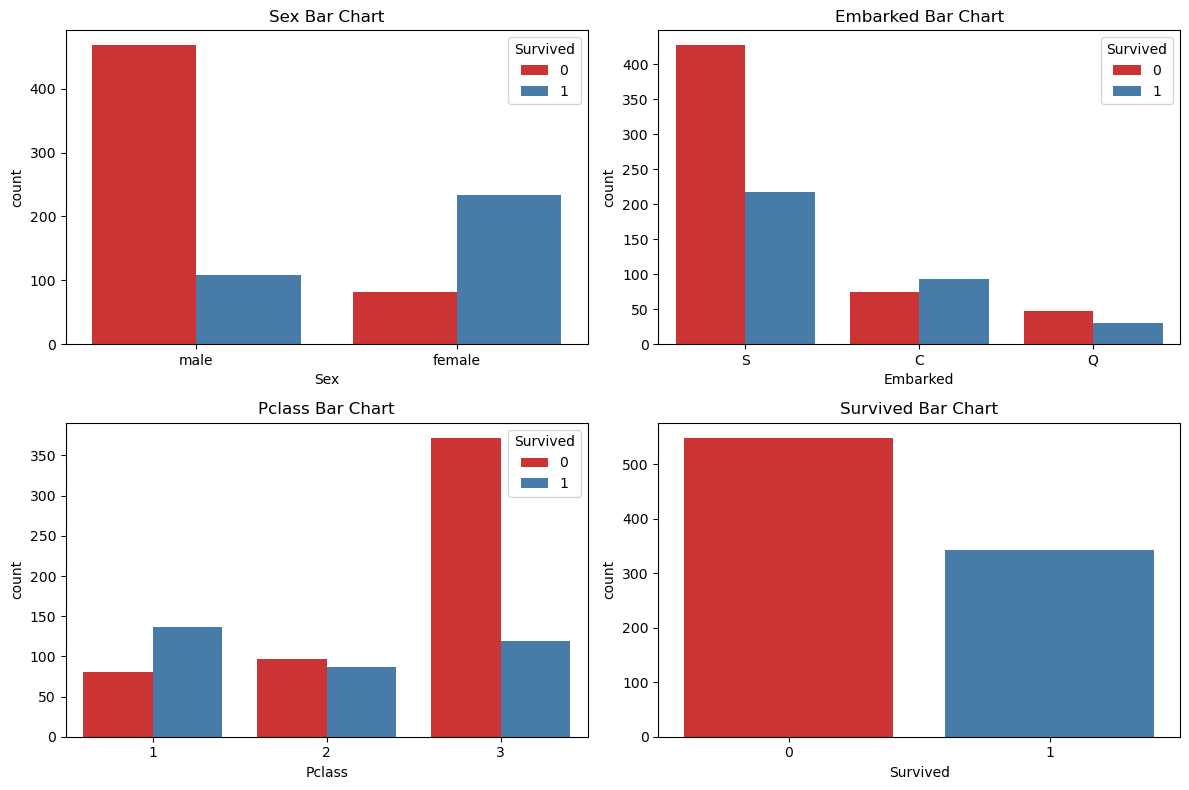

In [9]:
all_cat = categorical + [target]
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
for i in range(len(ax)):
    if all_cat[i] != "Survived":
        count = sns.countplot(x=all_cat[i], data=data_train, ax=ax[i], hue="Survived", palette='Set1')
    else:
        count = sns.countplot(x=all_cat[i], data=data_train, ax=ax[i], hue=all_cat[i], palette='Set1', legend=False)
    ax[i].set_title(f"{all_cat[i]} Bar Chart")

plt.tight_layout()
#plt.savefig('Categ_countplot.png', dpi=300)
plt.show()

Основные моменты:
* На борту было в два раза больше мужчин, чем женщин. Однако большинство мужчин, в отличие от женщин, не выжили.
* Более 70% этих пассажиров погрузились на корабль в порту S (Southampton). 
* Большинство пассажиров с билетами 3-го класса не выжили. Для 2 класса доли практически равны. В 1-м классе больше всего выживших.
* В целом, около 60% пассажиров не выжили в результате аварии.

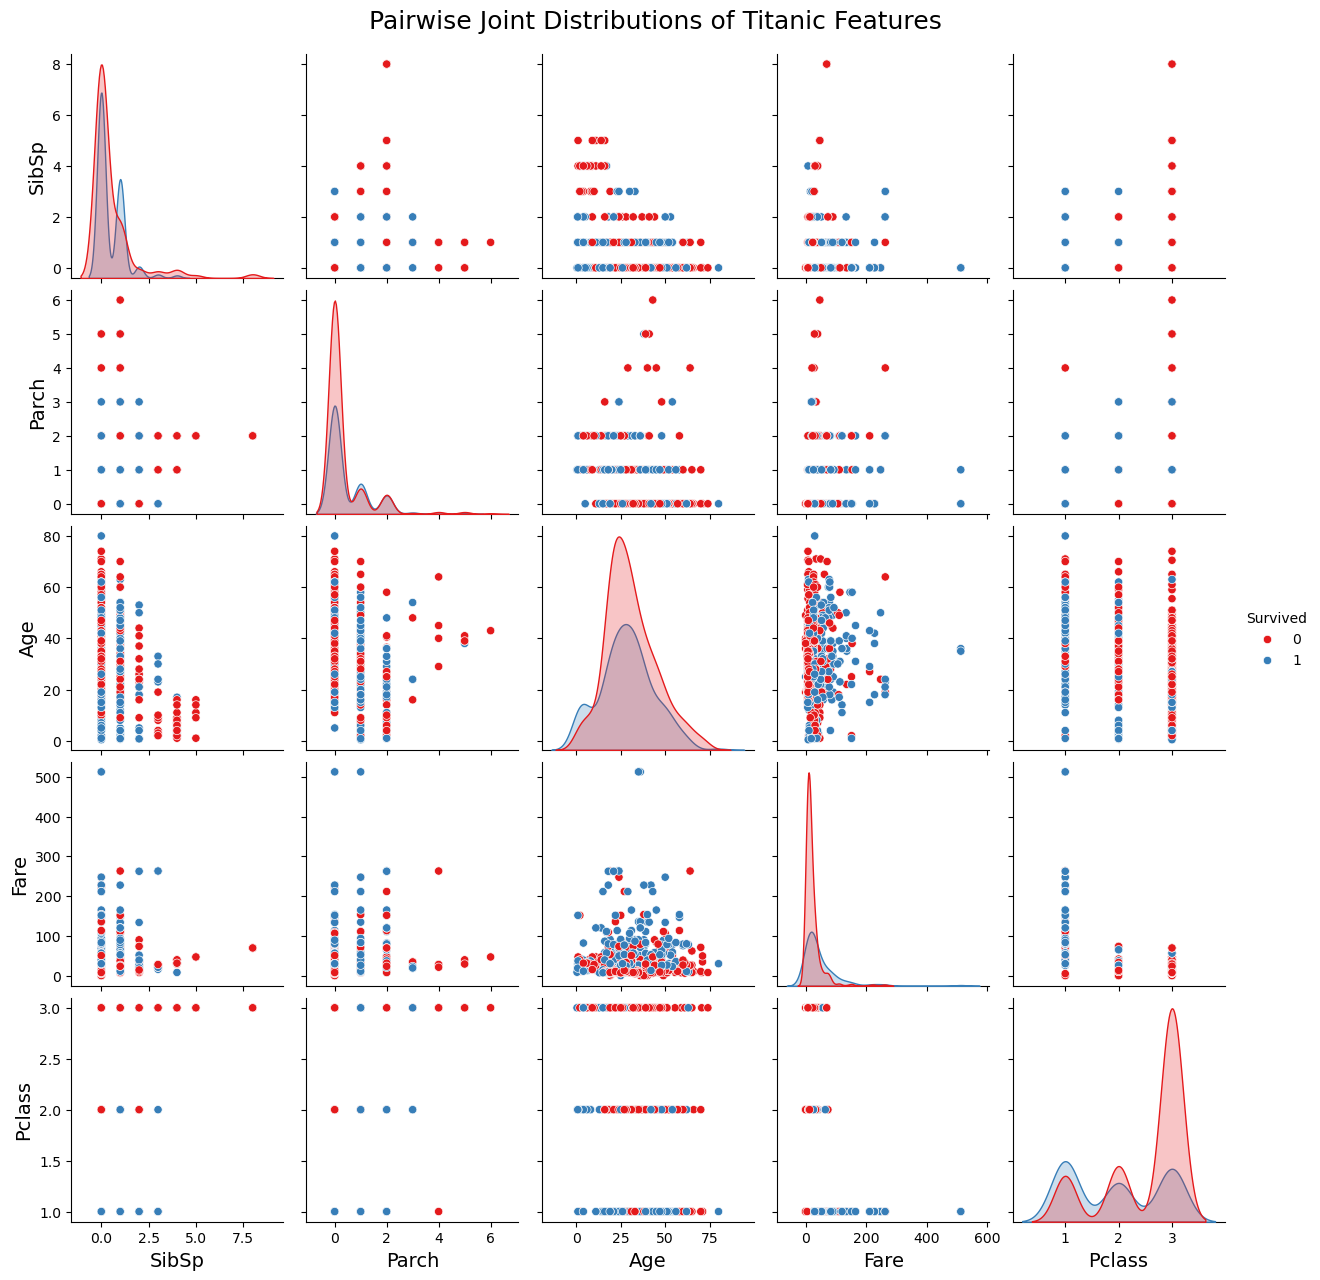

In [10]:
# Графики совместного распределения
pair_plot = sns.pairplot(data_train[["SibSp", "Parch", "Age", "Fare", "Pclass", 'Survived', 'Sex', "Embarked"]], hue='Survived', palette="Set1")
for ax in pair_plot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
pair_plot.fig.suptitle('Pairwise Joint Distributions of Titanic Features', y=1.02, fontsize=18)
#plt.savefig('Joint_distr.png', dpi=300)
plt.show()

**Посмотрим на оставшиеся столбцы.**

* PassengerId

In [11]:
print("Количество уникальных PassengerId:", len(np.unique(data_train["PassengerId"])))
print("Количество наблюдений в данных:", len(data_train))

Количество уникальных PassengerId: 891
Количество наблюдений в данных: 891


Эта переменная содержит только уникальный идентификационный номер каждого пассажира и не будет полезна в модели, можем просто удалить её.

* Name

In [12]:
data_train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

Как мы видим, в именах пассажиров есть обращения (Mr, Miss, Mrs и пр.), можно сделать из них отдельную переменную.

In [13]:
data_train["Title_raw"] = data_train["Name"].str.extract('([A-Za-z]+)\.')
data_train["Title_raw"].value_counts()

Title_raw
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

In [14]:
# Объединим некоторые обращения, а малочисленные - в одну группу Other
title_mapping = {
    "Ms": "Miss",
    "Mlle": "Miss",
    "Miss": "Miss",
    "Mme": "Mrs",
    "Mrs": "Mrs",
    "Mr": "Mr",
    "Master": "Master"
}

data_train["Title"] = data_train["Title_raw"].map(title_mapping).fillna("Other")
data_train["Title"].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

* Ticket

In [15]:
data_train["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [16]:
print("Количество уникальных Ticket:", len(np.unique(data_train["Ticket"])))
print("Количество наблюдений в данных:", len(data_train))

Количество уникальных Ticket: 681
Количество наблюдений в данных: 891


Не все значения уникальны, посмотрим на самые частые.

In [17]:
data_train.Ticket.value_counts()[:15]

Ticket
347082          7
CA. 2343        7
1601            7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
LINE            4
PC 17757        4
17421           4
349909          4
113760          4
4133            4
113781          4
Name: count, dtype: int64

In [18]:
data_train[data_train["Ticket"] == "347082"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_raw,Title
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,Mr,Mr
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,Miss,Miss
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,Miss,Miss
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,Miss,Miss
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,Mrs,Mrs
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,Miss,Miss
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,Master,Master


In [19]:
data_train[data_train["Ticket"] == "1601"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_raw,Title
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,Mr,Mr
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,Mr,Mr
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,Mr,Mr
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,Mr,Mr
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,Mr,Mr
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,Mr,Mr
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,Mr,Mr


В билете "347082" это семья с детьми, в билете "1601" - нет (мужчины примерно одного возраста, может какая-то команда). Так что эта переменная содержит только уникальное значение билета на некоторую группу людей.

### Задание: провести такое же описание пассажиров отдельно для каждого класса билета. Составить средний портрет пассажира каждого класса

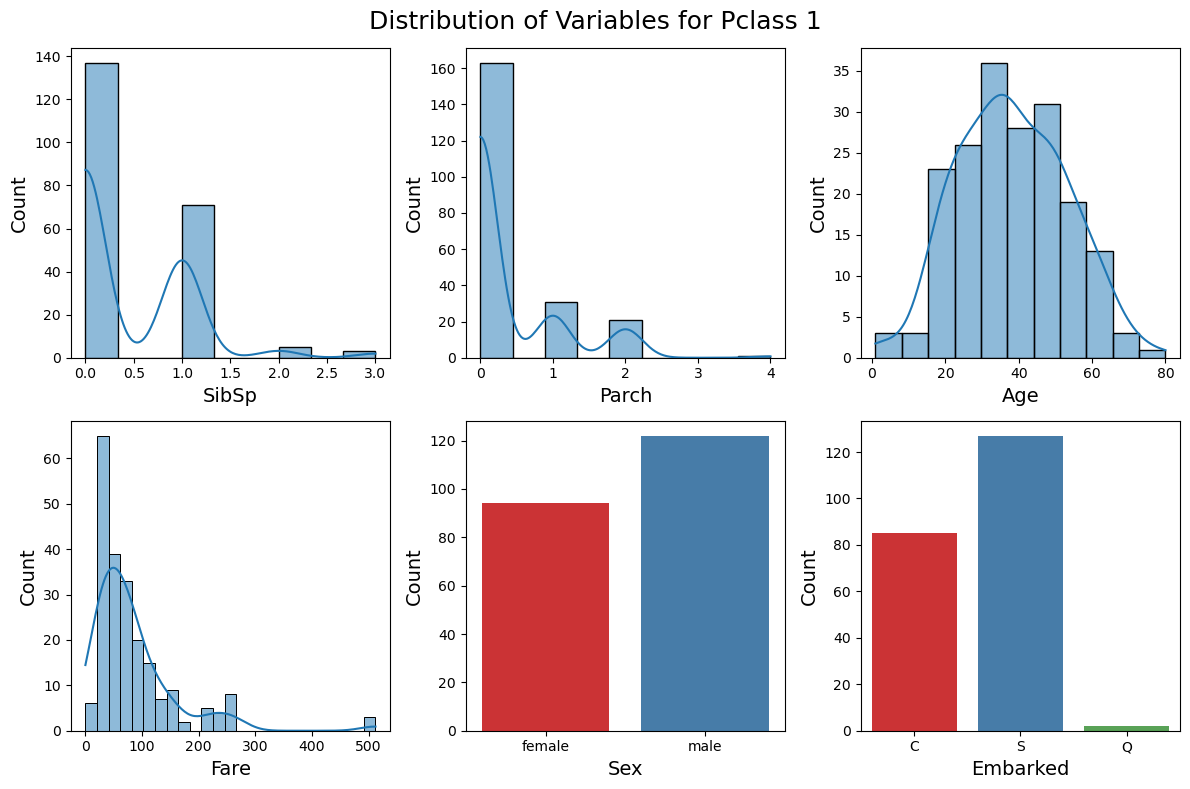

Mean SibSp: 0.42
Mean Parch: 0.36
Mean Age: 38.23
Mean Fare: 84.15
Mode Sex: male
Mode Embarked: S
Mean Survived: 0.63
-------------------------------------------------------------------------------------------------------------------------------


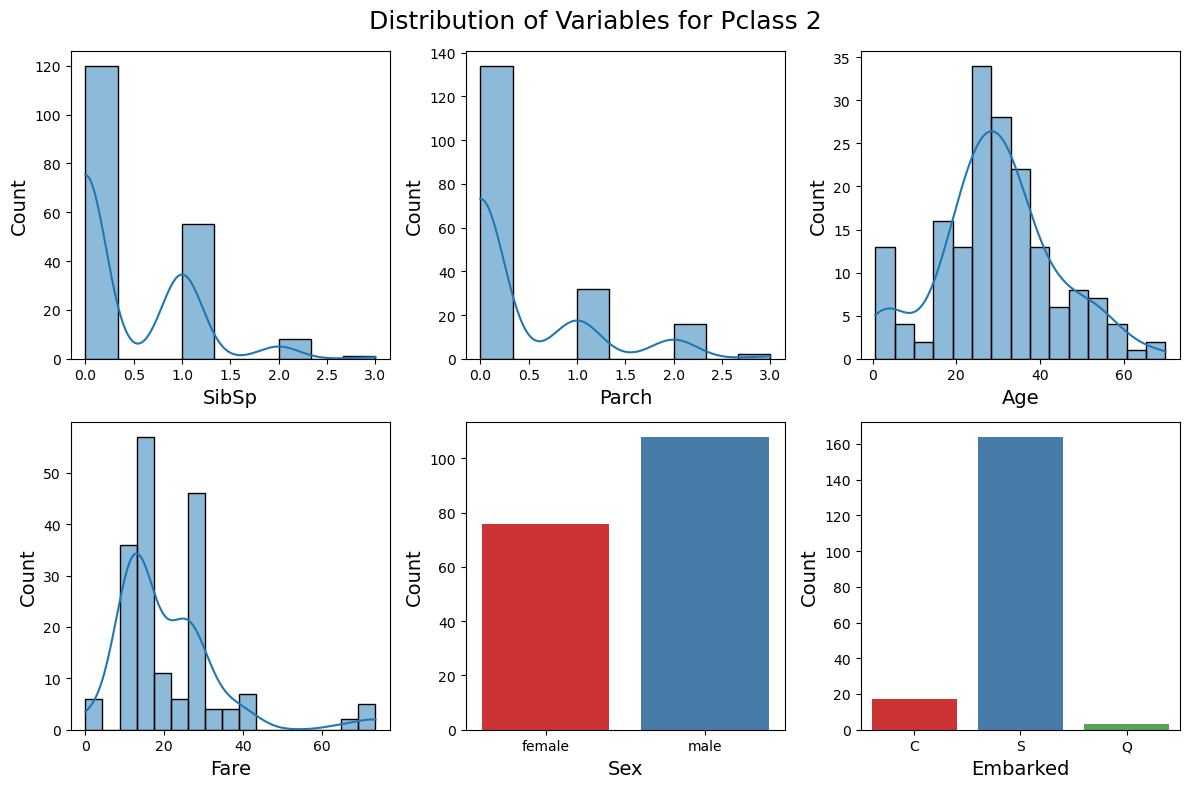

Mean SibSp: 0.4
Mean Parch: 0.38
Mean Age: 29.88
Mean Fare: 20.66
Mode Sex: male
Mode Embarked: S
Mean Survived: 0.47
-------------------------------------------------------------------------------------------------------------------------------


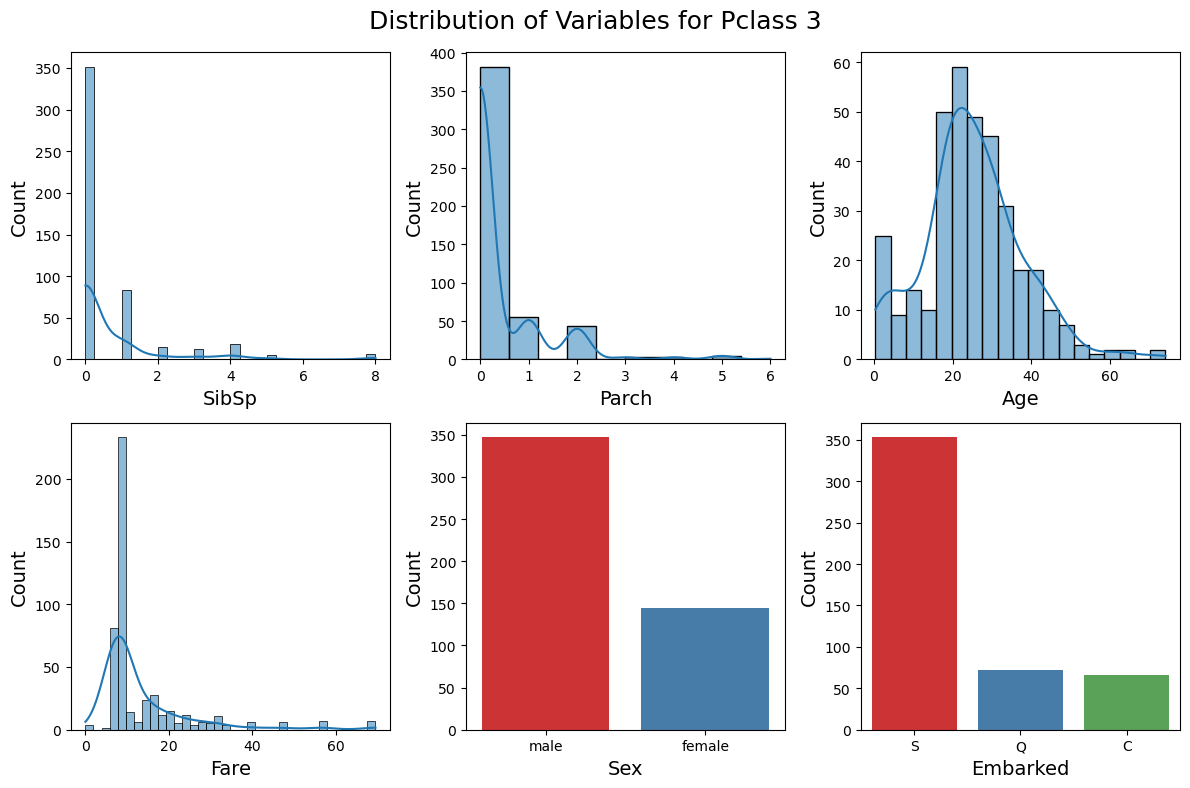

Mean SibSp: 0.62
Mean Parch: 0.39
Mean Age: 25.14
Mean Fare: 13.68
Mode Sex: male
Mode Embarked: S
Mean Survived: 0.24
-------------------------------------------------------------------------------------------------------------------------------


In [23]:
def plot_by_pclass(data, selected_pclass):
    numerical = ["SibSp", "Parch", "Age", "Fare"]
    categorical = ["Sex", "Embarked"]
    target = ["Survived"]
    variables = numerical + categorical + target
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Distribution of Variables for Pclass {selected_pclass}', fontsize=18) 
    ax = ax.flatten()
    for i in range(len(ax)):
        if variables[i] in numerical:
            sns.histplot(data[data['Pclass'] == selected_pclass][variables[i]].dropna(), kde=True, ax=ax[i])
        elif variables[i] in target:
            continue
        else:
            sns.countplot(x=variables[i], data=data[data['Pclass'] == selected_pclass], hue=variables[i], palette='Set1', legend=False, ax=ax[i])
        
        ax[i].set_xlabel(f'{variables[i]}', fontsize=14)  
        ax[i].set_ylabel('Count', fontsize=14)  

    plt.tight_layout()
    plt.savefig(f'Pclass_{selected_pclass}.png', dpi=300)
    plt.show()

    for i in range(len(variables)):
        if variables[i] in numerical or variables[i] in target:
            mean_value = round(data[data['Pclass'] == selected_pclass][variables[i]].mean(), 2)
            print(f"Mean {variables[i]}: {mean_value}")
        elif variables[i] in ["Sex", "Embarked"]:
            mode_value = data[data['Pclass'] == selected_pclass][variables[i]].mode().iloc[0]
            print(f"Mode {variables[i]}: {mode_value}")
    print('-'*127)

    
for value in sorted(data_train['Pclass'].unique()):
    plot_by_pclass(data_train, value)

Средний портрет пассажира каждого класса.
* 1 класс: пассажир мужчина, сел на Титаник в Southampton. Вероятнеее всего путешествует один, может быть с супругой и детьми. Ему около 40 лет. Заплатил за билет больше, чем любой другой класс (84 долларов в среднем).
* 2 класс: пассажир мужчина, сел на Титаник в Southampton. Вероятнеее всего путешествует один, может быть с супругой и детьми . Ему 30 лет. Заплатил за билет примерно 20 долларов.
* 3 класс:     • пассажир мужчина, сел на Титаник в Southampton. Вероятнеее всего путешествует один. Ему 25 лет. Заплатил за билет мало, вероятно около 14 долларов.


### Задание: Провести такое же описание пассажиров отдельно для каждого диапазона возраста (<14, 14-21, 21-35, 35-55, >55). Составить средний портрет пассажира каждого возрастного диапазона

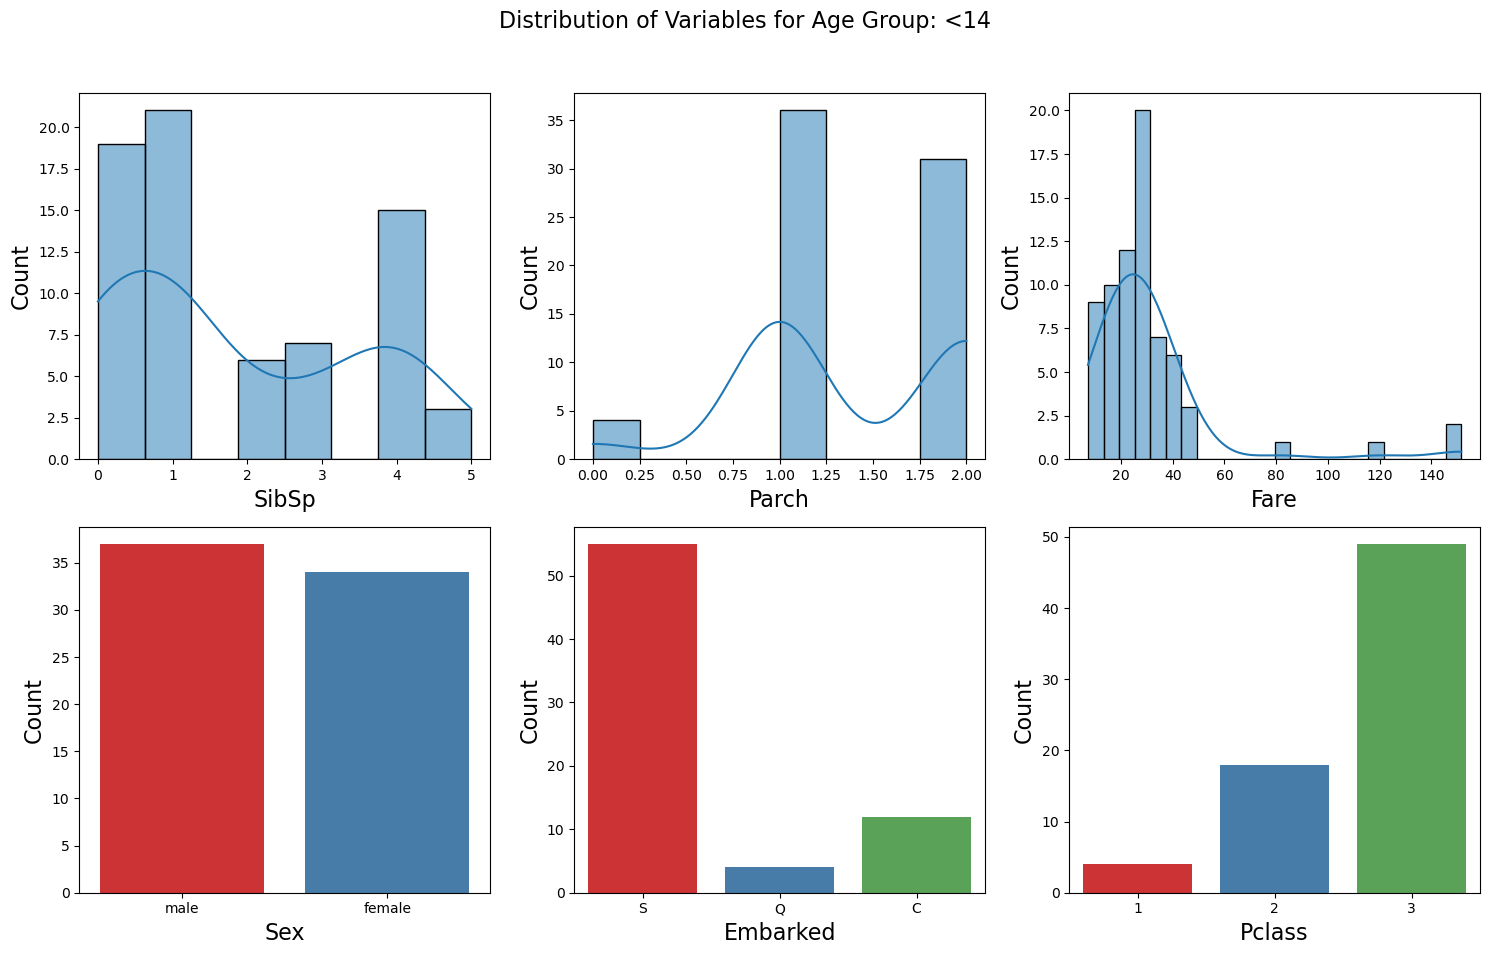

Mean values for Age Group <14
Mean SibSp: 1.82
Mean Parch: 1.38
Mean Fare: 31.02
Mode Sex: male
Mode Embarked: S
Mode Pclass: 3
Mean Survived: 0.59
-------------------------------------------------------------------------------------------------------------------------------


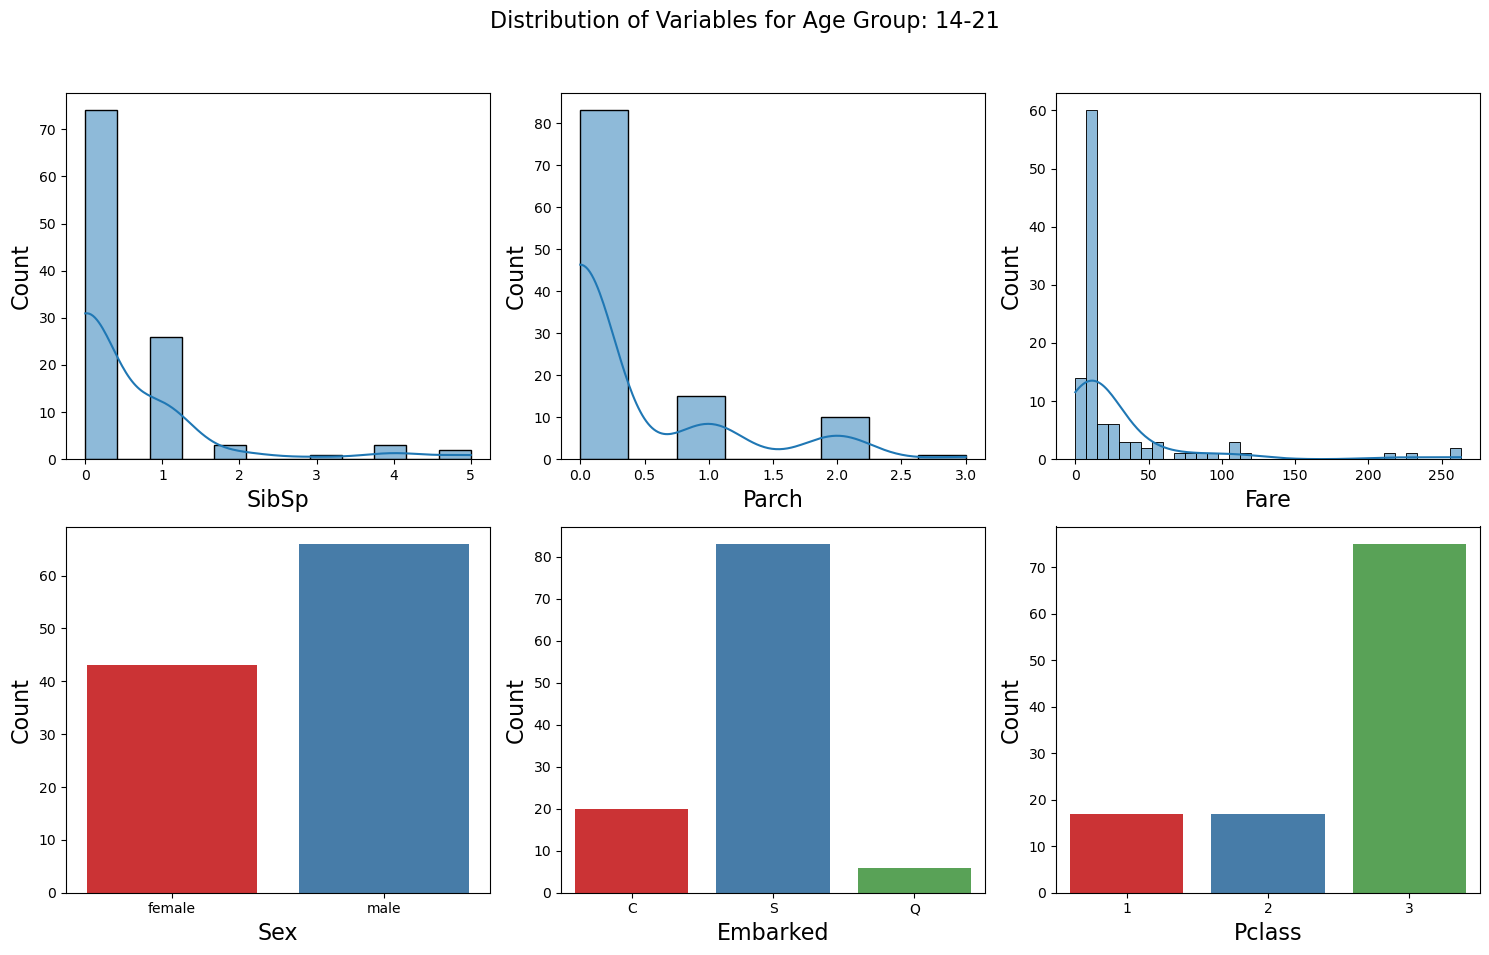

Mean values for Age Group 14-21
Mean SibSp: 0.52
Mean Parch: 0.35
Mean Fare: 28.88
Mode Sex: male
Mode Embarked: S
Mode Pclass: 3
Mean Survived: 0.37
-------------------------------------------------------------------------------------------------------------------------------


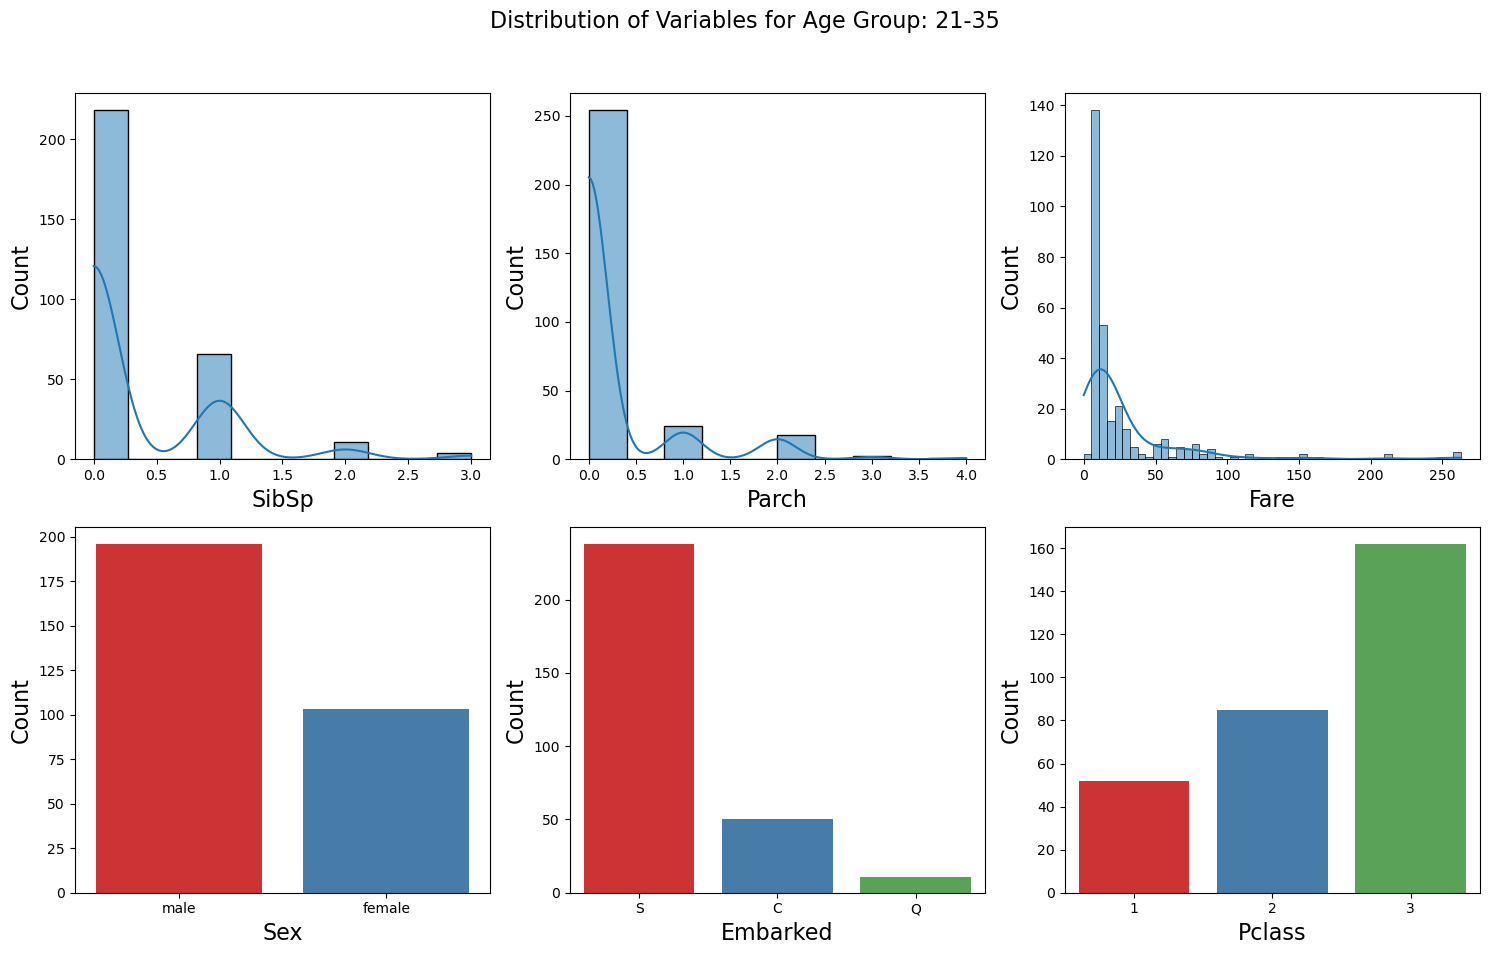

Mean values for Age Group 21-35
Mean SibSp: 0.33
Mean Parch: 0.23
Mean Fare: 27.67
Mode Sex: male
Mode Embarked: S
Mode Pclass: 3
Mean Survived: 0.38
-------------------------------------------------------------------------------------------------------------------------------


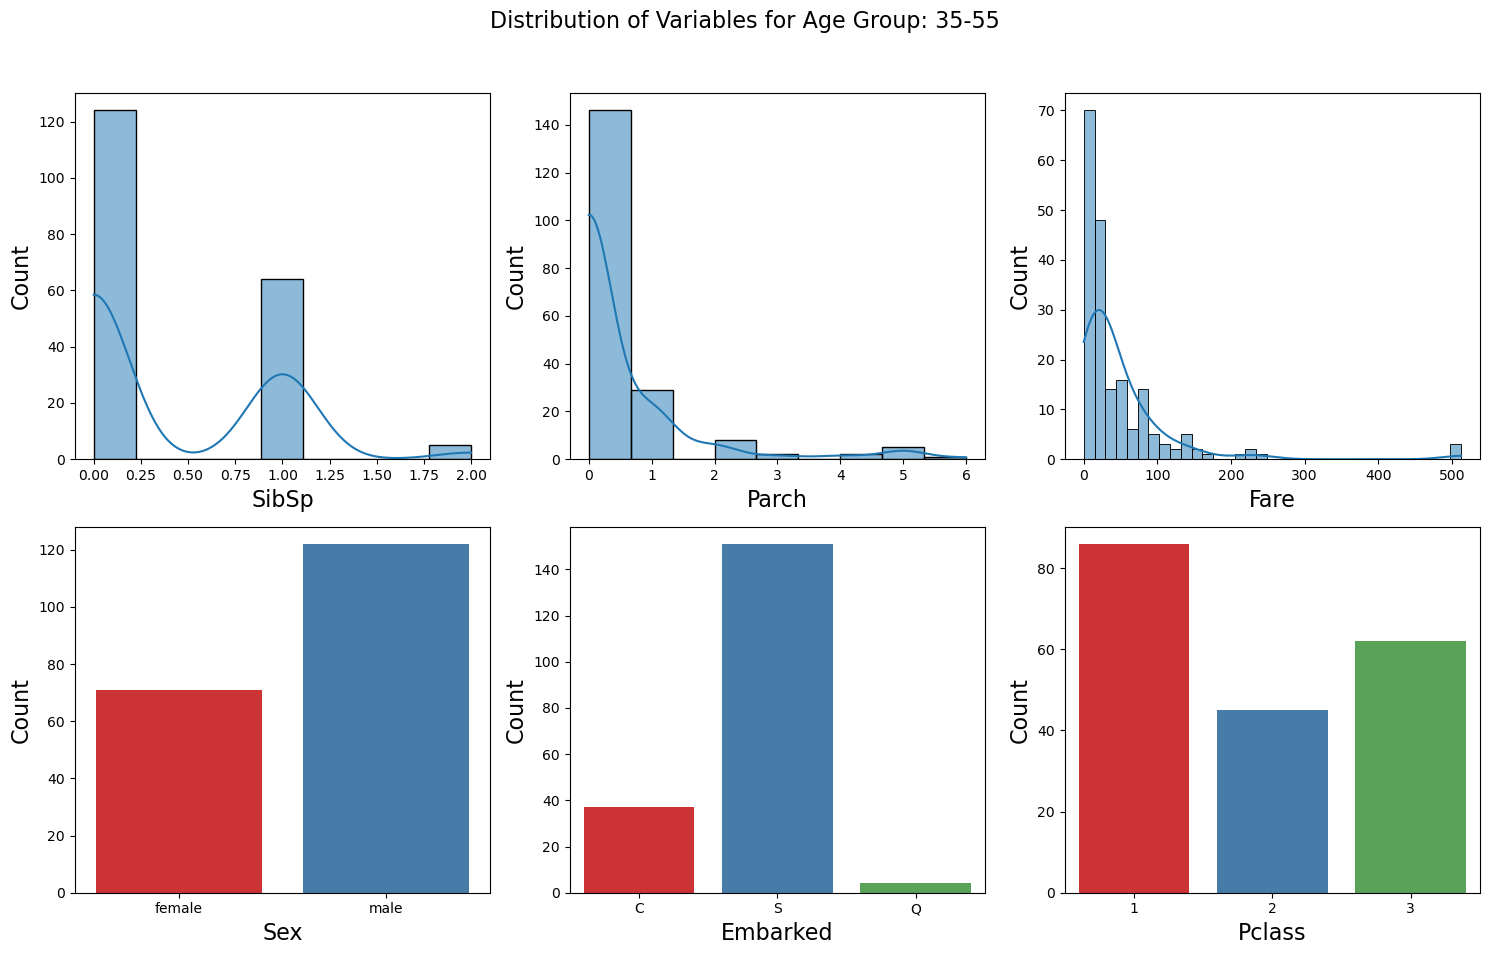

Mean values for Age Group 35-55
Mean SibSp: 0.38
Mean Parch: 0.47
Mean Fare: 48.06
Mode Sex: male
Mode Embarked: S
Mode Pclass: 1
Mean Survived: 0.42
-------------------------------------------------------------------------------------------------------------------------------


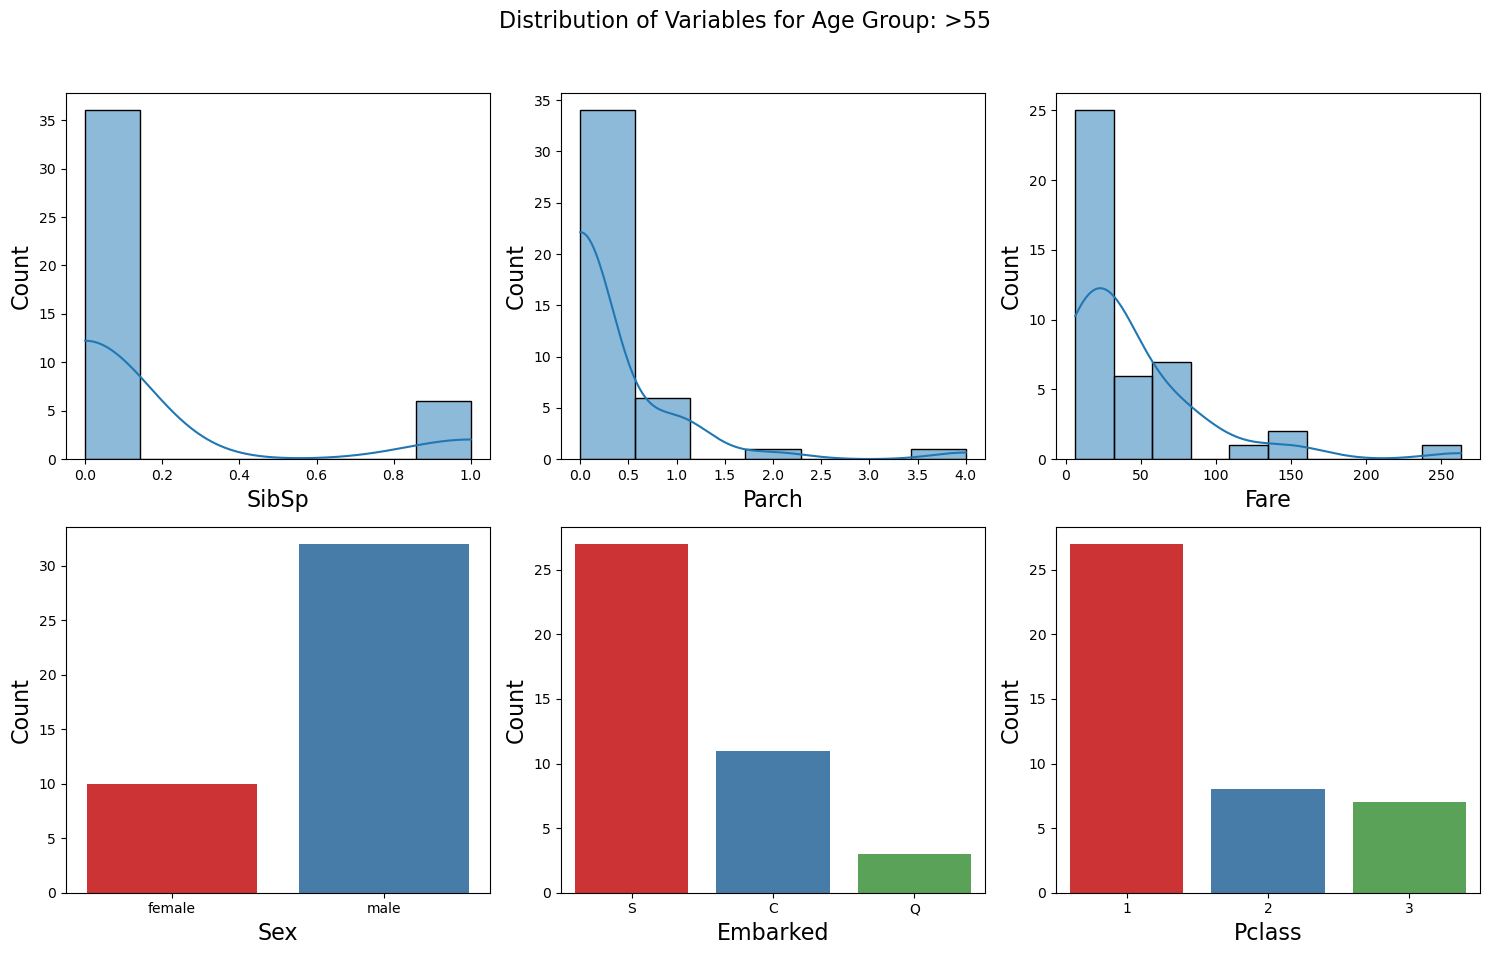

Mean values for Age Group >55
Mean SibSp: 0.14
Mean Parch: 0.29
Mean Fare: 44.61
Mode Sex: male
Mode Embarked: S
Mode Pclass: 1
Mean Survived: 0.31
-------------------------------------------------------------------------------------------------------------------------------


In [30]:
# Диапазоны возраста
age_bins = [0, 14, 21, 35, 55, 100]
age_labels = ['<14', '14-21', '21-35', '35-55', '>55']

# Добавлю новую колонку AgeGroup
data_train['AgeGroup'] = pd.cut(data_train['Age'], bins=age_bins, labels=age_labels, right=False)

def desc_age_group(data, age_label):
    numerical = ["SibSp", "Parch", "Fare"]
    categorical = ["Sex", "Embarked", "Pclass"]
    target = ["Survived"]

    selected_age_group = age_label
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Distribution of Variables for Age Group: {selected_age_group}', fontsize=16)

    for i, num_var in enumerate(numerical):
        sns.histplot(data[data['AgeGroup'] == selected_age_group][num_var].dropna(), kde=True, ax=axes[0, i])
        axes[0, i].set_xlabel(f'{num_var}', fontsize=16)
        axes[0, i].set_ylabel('Count', fontsize=16)

    for i, cat_var in enumerate(categorical):
        sns.countplot(x=cat_var, data=data[data['AgeGroup'] == selected_age_group], hue=cat_var, palette='Set1', legend=False, ax=axes[1, i])
        axes[1, i].set_xlabel(f'{cat_var}', fontsize=16)
        axes[1, i].set_ylabel('Count', fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    name = ''.join(re.findall(r'\d', age_label))
    plt.show()


    print(f"Mean values for Age Group {selected_age_group}")
    for var in ["SibSp", "Parch", "Fare", "Sex", "Embarked", "Pclass", "Survived"]:
        if var in numerical or var in target:
            mean_value = round(data[data['AgeGroup'] == selected_age_group][var].mean(), 2)
            print(f"Mean {var}: {mean_value}")
        elif var in ["Sex", "Embarked"]:
            mode_value = data[data['AgeGroup'] == selected_age_group][var].mode().iloc[0]
            print(f"Mode {var}: {mode_value}")
        elif var == "Pclass":
            mode_value = data[data['AgeGroup'] == selected_age_group][var].value_counts().idxmax()
            print(f"Mode {var}: {mode_value}")

    print('-' * 127)


for age in age_labels:
    desc_age_group(data_train, age)

Cредний портрет пассажира каждого возрастного диапазона:
* $<14$: пассажир сел на Титаник в Southampton. Это может быть почти в равной степени как мальчик, так и девочка. На корабле находится с 1 или 2 родителями, а также с 2 братьями/сестрами. Куплен билет 3го класса, стоил 31 доллар.
* $14-21$: пассажир сел на Титаник в Southampton, мужчина. На корабле находится в одиночку, может быть с кем-то из членов семьи. Билет 3го класса, стоил 29 долларов.
* $21-35$: пассажир сел на Титаник в Southampton, мужчина. На корабле находится в одиночку. Билет 3го класса, стоил 28 долларов.
* $35-55$: пассажир сел на Титаник в Southampton, мужчина . На корабле находится в одиночку или с супругой (среднее близко к 0.5). Билет 1го класса, средняя стоимость 48.
* $>55$: пассажир сел на Титаник в Southampton, мужчина. На корабле находится в одиночку. Билет 1го класса, средняя стоимость 44.

### Задание: На основе данных о пасажире научиться предсказывать в какой класс он попадет + научиться предсказывать выживет ли он или нет. Построить пайплайн для обучения и валидации модели. Провести эксперименты с разными моделями logisitc regression, decision tree, svm.

В переменной Age отсутствует почти 20% значений. Попробуем заполнить отсутствующие значения. Обычно мы можем просто заполнить их средним или медианным значением. Но проблема в том, что этот набор данных содержит множество пассажиров разного возраста. Проверим корреляцию между переменной Age и другими переменными.

In [24]:
data_train[numerical].corr()["Age"].sort_values(ascending=False)

Age      1.000000
Fare     0.096067
Parch   -0.189119
SibSp   -0.308247
Name: Age, dtype: float64

Ничего особенного. Попробуем посмотреть на категориальные переменные.

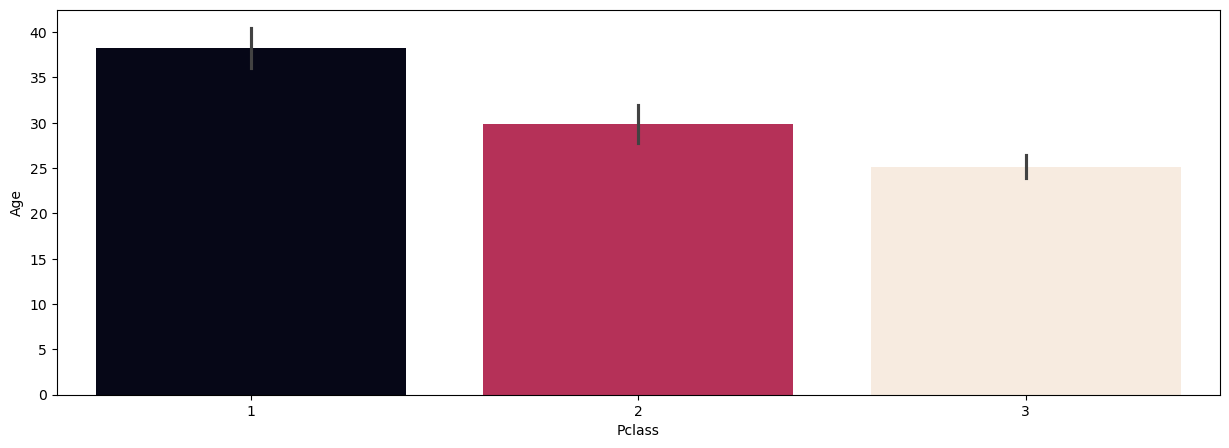

In [25]:
plt.figure(figsize=(15,5))
sns.barplot(x=data_train['Pclass'], y=data_train['Age'], hue = data_train['Pclass'], palette = 'rocket', legend=False);

Неплохо, но опять же в одном классе могут быть люди очень разного возраста.

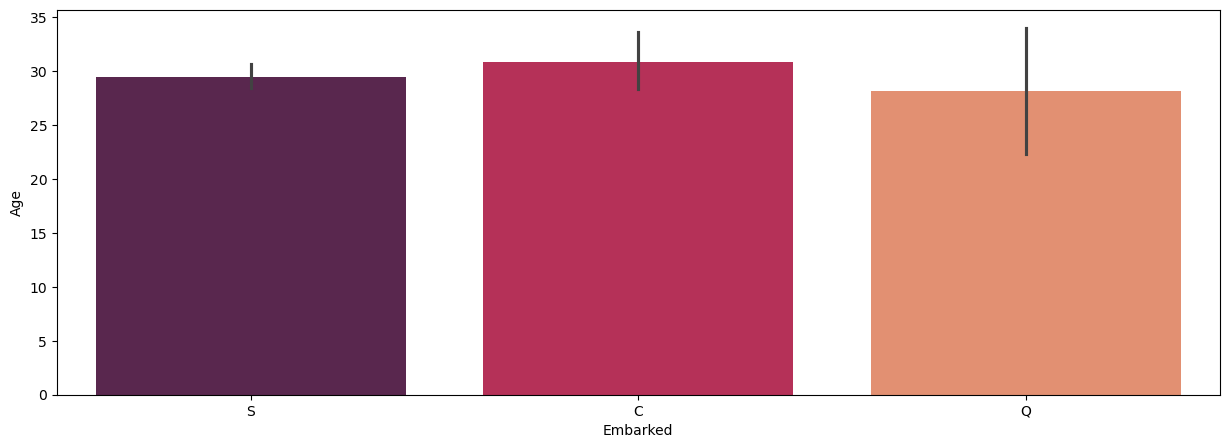

In [26]:
plt.figure(figsize=(15,5))
sns.barplot(x=data_train['Embarked'], y=data_train['Age'], hue = data_train['Embarked'], palette = 'rocket', legend=False);

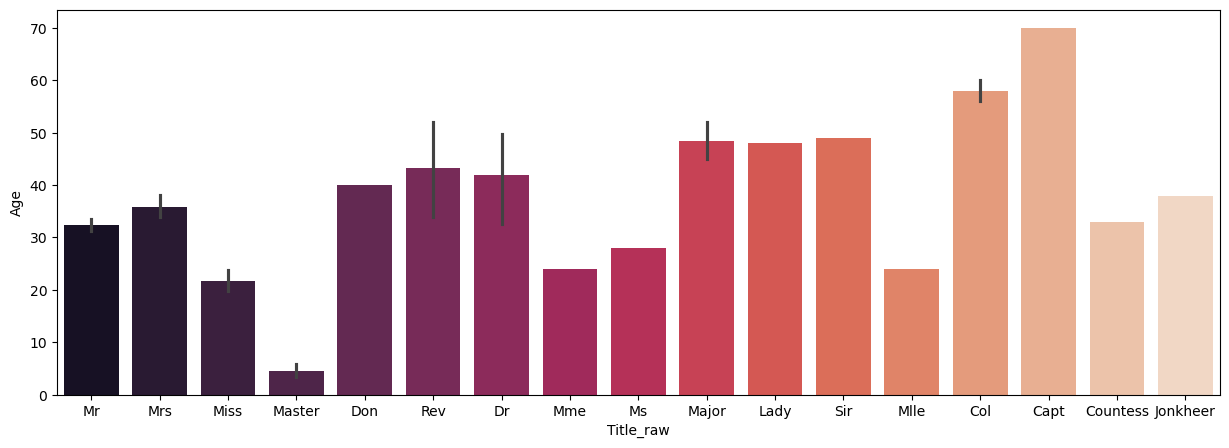

In [27]:
plt.figure(figsize=(15,5))
sns.barplot(x=data_train['Title_raw'], y=data_train['Age'], hue = data_train['Title_raw'], palette = 'rocket', legend=False);

Вывод: будем использовать среднее значение по обращению в имени пассажира для заполнения возраста.

Посмотрим корреляцию.

Text(0.5, 1.05, 'Корреляция фичей')

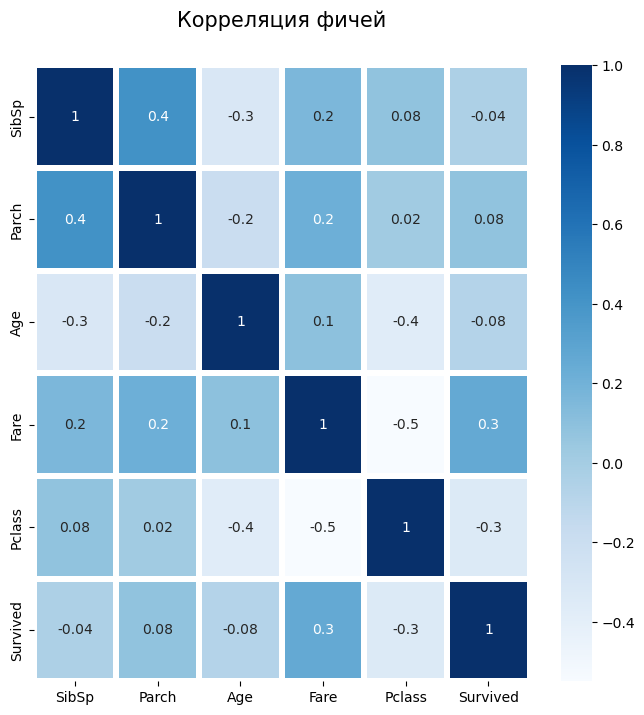

In [28]:
corr = data_train[["SibSp", "Parch", "Age", "Fare", "Pclass", 'Survived']].corr()
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='Blues', fmt='.1g')
plt.title("Корреляция фичей", y=1.05, size=15)

**Построим пайплайн для обучения моделей.**

In [29]:
def prepare_data(data, predict_var):

    data.drop(data[pd.isnull(data['Embarked'])].index, inplace=True)
    data["Title_raw"] = data["Name"].str.extract('([A-Za-z]+)\.')
    
    title_mapping = {
        "Ms": "Miss",
        "Mlle": "Miss",
        "Miss": "Miss",
        "Mme": "Mrs",
        "Mrs": "Mrs",
        "Mr": "Mr",
        "Master": "Master"
    }

    data["Title"] = data["Title_raw"].map(title_mapping).fillna("Other")

    means = data.groupby('Title_raw')['Age'].mean()
    map_means = means.to_dict()
    idx_nan_age = data['Age'].isnull()
    data.loc[idx_nan_age, 'Age'] = data['Title_raw'].map(map_means)
    
    data['Relatives'] = data['SibSp'] + data['Parch']

    data.drop(columns=['Cabin', 'PassengerId', 'Ticket', 'Name', 'Title_raw'], inplace=True)

    data['Sex'] = pd.Categorical(data['Sex'])
    data['Embarked'] = pd.Categorical(data['Embarked'])
    data['Title'] = pd.Categorical(data['Title'])
    if predict_var == 'Survived':
        data['Pclass'] = pd.Categorical(data['Pclass'])
    data = pd.get_dummies(data, drop_first=True, dtype=int)

    return data

In [30]:
def split_train_test(data, predict_var):
    X = data[[col for col in data.columns if col not in [predict_var]]]
    y = data[predict_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    return X_train, X_test, y_train, y_test

In [31]:
def train_models(X_train, X_test, y_train, y_test, classifiers, param_grids):
    results = pd.DataFrame(columns=["Classifier", "Best Params", "Train Accuracy", "Test Accuracy"])
    for name, clf in classifiers.items():
        print(f"Train {name} model")

        model = clf
        param_grid = param_grids[name]

        start = time.time()
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        end = time.time()
        print('Training time:', end - start)

        print("Best Hyperparameters:", grid_search.best_params_)
        best_model = grid_search.best_estimator_

        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        accuracy_train = accuracy_score(y_train, y_pred_train)
        accuracy_test = accuracy_score(y_test, y_pred_test)

        print("Accuracy on the train set:", accuracy_train)
        print("Accuracy on the test set:", accuracy_test)

        results.loc[len(results)] = [name, 
                                    grid_search.best_params_, 
                                    accuracy_train, 
                                    accuracy_test]

        print("-----------------------------------------------------\n")

    results = results.sort_values("Test Accuracy", ascending=False)
    
    results = results.reset_index()
    results = results.drop(columns = ['index'])

    return results

In [32]:
# Классификаторы
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=10000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "LGBM": LGBMClassifier()
}

# Сетка параметров
param_grids = {
    "KNN": {'n_neighbors': [9, 15, 20, 30 , 40],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
           }, 
    "LR": {'C': np.logspace(-4, 4, 9), 
           'tol': [0.1, 0.01, 0.001, 0.0001],
            "solver": ['lbfgs', 'liblinear']
          }, 
    "DT": {'criterion': ['gini', 'entropy'],
           'max_depth': [2, 5, 10, 20, 30],
           'min_samples_split': [5, 10, 20],
           'min_samples_leaf': [4, 5, 10]
          },
    "RF": {'n_estimators': [50, 100, 200],
           'max_depth': [2, 5, 10, 20, 30],
           'min_samples_split': [5, 10, 20],
           'min_samples_leaf': [5, 10, 20],
           'bootstrap': [True, False]
          },
    "SVM": {'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
           },
    "LGBM": {'num_leaves': [30, 50, 100],
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 200],
             'max_depth': [10, 20],
             'min_child_samples': [20, 40, 60],
             'reg_alpha': [0.0, 0.1],
             'reg_lambda': [0.0, 0.1]
            }
}            

**Предсказываем класс.**

In [33]:
data_train = pd.read_csv("train.csv")
data_prepare_pclass = prepare_data(data_train, 'Pclass')
X_train, X_test, y_train, y_test = split_train_test(data_prepare_pclass, 'Pclass')

pclass_result = train_models(X_train, X_test, y_train, y_test, classifiers, param_grids)

pd.set_option('display.max_colwidth', None)
pclass_result

Train KNN model
Training time: 0.6971273422241211
Best Hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Accuracy on the train set: 0.9985935302390999
Accuracy on the test set: 0.8764044943820225
-----------------------------------------------------

Train LR model
Training time: 23.06580352783203
Best Hyperparameters: {'C': 1.0, 'solver': 'lbfgs', 'tol': 0.1}
Accuracy on the train set: 0.8396624472573839
Accuracy on the test set: 0.8033707865168539
-----------------------------------------------------

Train DT model
Training time: 1.8962898254394531
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy on the train set: 0.9535864978902954
Accuracy on the test set: 0.9157303370786517
-----------------------------------------------------

Train RF model
Training time: 184.39051699638367
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators

,Classifier,Best Params,Train Accuracy,Test Accuracy
0,LGBM,"{'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 200, 'num_leaves': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.0}",0.998594,0.943820
1,DT,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}",0.953586,0.915730
2,RF,"{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}",0.966245,0.898876
3,KNN,"{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}",0.998594,0.876404
4,SVM,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.995781,0.859551
5,LR,"{'C': 1.0, 'solver': 'lbfgs', 'tol': 0.1}",0.839662,0.803371


**Предсказываем выживет или нет.**

In [35]:
data_train = pd.read_csv("train.csv")
data_prep_survived = prepare_data(data_train, 'Survived')
X_train, X_test, y_train, y_test = split_train_test(data_prep_survived, 'Survived')

survived_result = train_models(X_train, X_test, y_train, y_test, classifiers, param_grids)

survived_result

Train KNN model
Training time: 0.6965429782867432
Best Hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Accuracy on the train set: 0.8185654008438819
Accuracy on the test set: 0.7415730337078652
-----------------------------------------------------

Train LR model
Training time: 9.808624982833862
Best Hyperparameters: {'C': 100.0, 'solver': 'lbfgs', 'tol': 0.1}
Accuracy on the train set: 0.8354430379746836
Accuracy on the test set: 0.8370786516853933
-----------------------------------------------------

Train DT model
Training time: 2.0810112953186035
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5}
Accuracy on the train set: 0.8635724331926864
Accuracy on the test set: 0.8426966292134831
-----------------------------------------------------

Train RF model
Training time: 186.6844301223755
Best Hyperparameters: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimato

,Classifier,Best Params,Train Accuracy,Test Accuracy
0,DT,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5}",0.863572,0.842697
1,LR,"{'C': 100.0, 'solver': 'lbfgs', 'tol': 0.1}",0.835443,0.837079
2,RF,"{'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 100}",0.842475,0.831461
3,LGBM,"{'learning_rate': 0.05, 'max_depth': 10, 'min_child_samples': 40, 'n_estimators': 200, 'num_leaves': 30, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.907173,0.825843
4,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.829817,0.820225
5,KNN,"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.818565,0.741573
